# Machine Learning with Broad Stock Market Timeseries - a SARIMA Rollercoaster


<a href="" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import dotenv
%load_ext dotenv

import warnings
warnings.filterwarnings("ignore")

IS_KAGGLE = os.getenv('IS_KAGGLE', 'True') == 'True'

if IS_KAGGLE:
    # Kaggle confgs
    print('Running in Kaggle...')
    %pip install yfinance
    %pip install statsmodels
    %pip install seaborn
    %pip install itertools
    %pip install scikit-learn

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print('Running Local...')

import yfinance as yf
from analysis_utils import load_ticker_prices_ts_df, load_ticker_ts_df

os.getcwd()

Running Local...


'c:\\Users\\adamd\\workspace\\quant_research'

# Financial Data

Collect market time series data (like stock prices, trading volumes, etc.).
Clean the data to handle missing values, outliers, or anomalies.
Ensure the data is in a time series format, typically with a timestamp.

In [2]:
START_DATE = "2009-01-01"
END_DATE = "2023-12-31"
DATA_DIR = "data"
INDEX = "Date"

os.makedirs(DATA_DIR, exist_ok=True)

TARGET_ETF = "SPY"  # S&P 500
RATES_INDEX = "^TNX"  # 10 Year Treasury Note Yield
VOLATILITY_INDEX = "^VIX"  # CBOE Volatility Index
MACRO_INDEX = "VEU"  # Vanguard FTSE All-World ex-US ETF
TECH_INDEX = "QQQ"
SMALLCAP_INDEX = "R2US.MI"

tickers_symbols = [
    TARGET_ETF,
    VOLATILITY_INDEX,
    RATES_INDEX,
    MACRO_INDEX,
    TECH_INDEX,
    SMALLCAP_INDEX,
]
INTERVAL = "1d"
tickers = {}
for symbol in tickers_symbols:
    cached_file_path = f"{DATA_DIR}/{symbol}-{START_DATE}-{END_DATE}-{INTERVAL}.csv"

    try:
        if os.path.exists(cached_file_path):
            df = pd.read_csv(cached_file_path, index_col=INDEX)
            df.index = pd.to_datetime(df.index)
            assert len(df) > 0
        else:
            df = yf.download(
                symbol,
                start=START_DATE,
                end=END_DATE,
                progress=False,
                interval=INTERVAL,
            )
            assert len(df) > 0
            df.to_csv(cached_file_path)
        df.fillna(0, inplace=True)
        tickers[symbol] = df
    except Exception as e:
        print(f"Error with {symbol}: {e}")


sp500_df = tickers.get(TARGET_ETF)
vix_df = tickers.get(VOLATILITY_INDEX)
t10ytt_df = tickers.get(RATES_INDEX)
veu_df = tickers.get(MACRO_INDEX)
qqq_df = tickers.get(TECH_INDEX)
rus_df = tickers.get(SMALLCAP_INDEX)

assert not sp500_df["Close"].isna().any().any()

rus_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-21,52.240002,52.279999,51.910000,52.060001,52.060001,28654
2023-12-22,52.549999,52.830002,52.070000,52.770000,52.770000,52588
2023-12-27,53.340000,53.340000,52.779999,52.799999,52.799999,19895
2023-12-28,53.209999,53.209999,52.799999,53.000000,53.000000,16963
2023-12-29,53.150002,53.200001,52.310001,52.330002,52.330002,14864


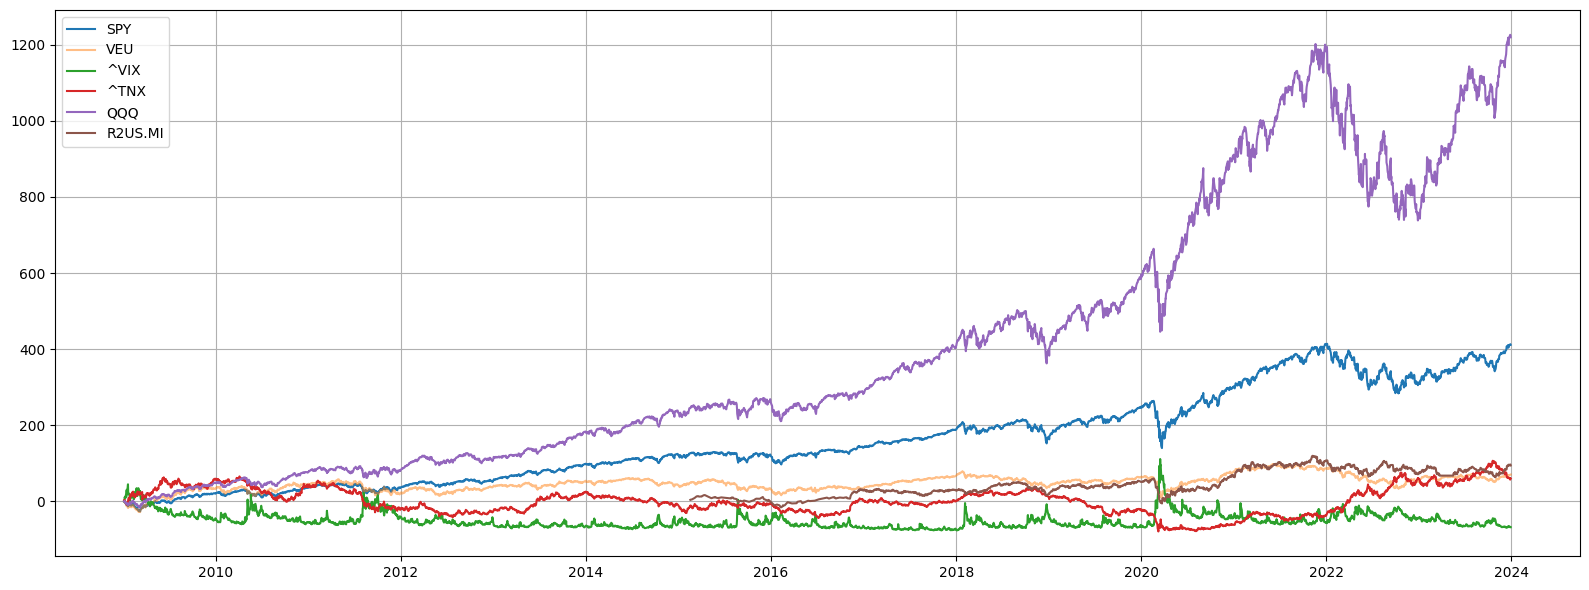

In [3]:
sp500_pr = ((1 + sp500_df["Close"].pct_change()).cumprod() - 1) * 100
veu_pr = ((1 + veu_df["Close"].pct_change()).cumprod() - 1) * 100
vix_pr = ((1 + vix_df["Close"].pct_change()).cumprod() - 1) * 100
tnx_pr = ((1 + t10ytt_df["Close"].pct_change()).cumprod() - 1) * 100
qqq_pr = ((1 + qqq_df["Close"].pct_change()).cumprod() - 1) * 100
rus_pr = ((1 + rus_df["Close"].pct_change()).cumprod() - 1) * 100

plt.figure(figsize=(16, 6))
plt.plot(sp500_pr, label=TARGET_ETF)
plt.plot(veu_pr, label=MACRO_INDEX, alpha=0.5)
plt.plot(vix_pr, label=VOLATILITY_INDEX)
plt.plot(tnx_pr, label=RATES_INDEX)
plt.plot(qqq_pr, label=TECH_INDEX)
plt.plot(rus_pr, label=SMALLCAP_INDEX)

plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

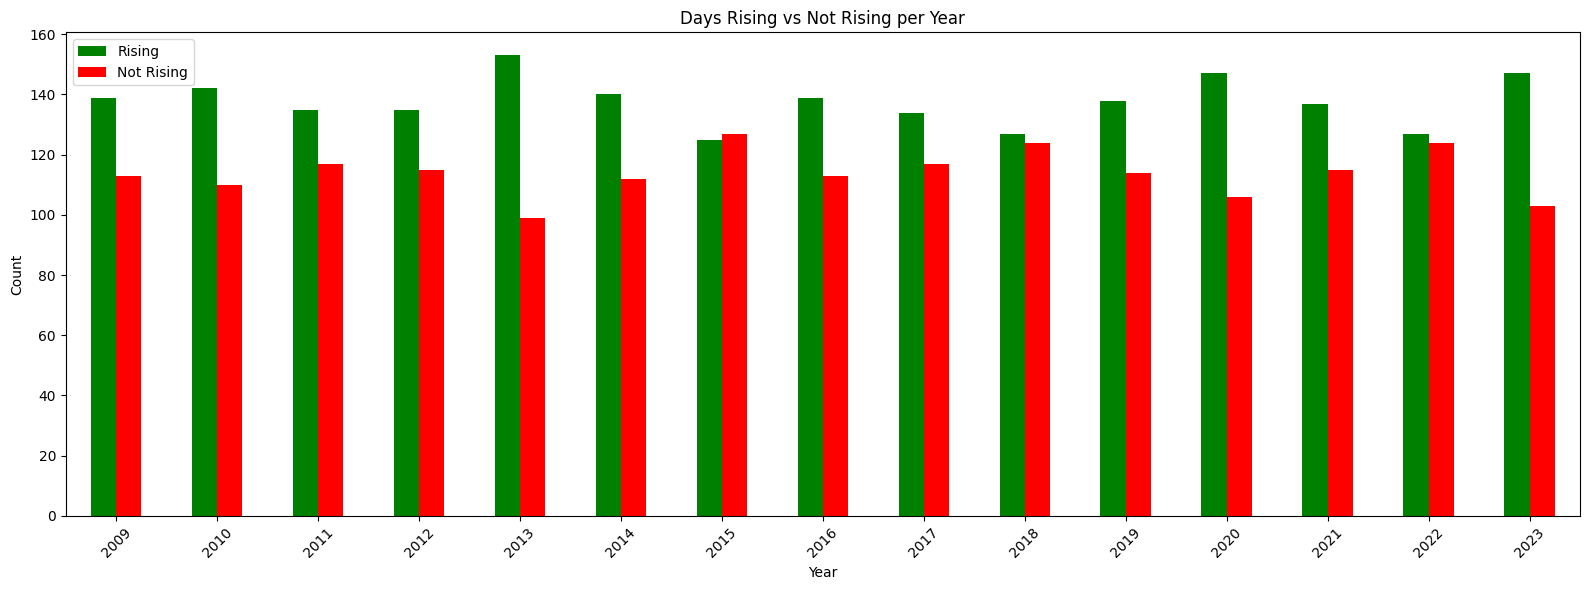

Baseline Accuracy: 54.71%


In [4]:
days_rising = sp500_df[sp500_df["Close"] > sp500_df["Open"]]
days_not_rising = sp500_df[sp500_df["Close"] <= sp500_df["Open"]]
days_rising_count = days_rising.groupby(days_rising.index.year).size()
days_not_rising_count = days_not_rising.groupby(days_not_rising.index.year).size()

total_days = sp500_df.groupby(sp500_df.index.year).size()
percentage_rising = (days_rising_count / total_days) * 100

yearly_counts = pd.DataFrame(
    {"Rising": days_rising_count, "Not Rising": days_not_rising_count}
)
yearly_counts.plot(kind="bar", color=["green", "red"], figsize=(16, 6))
plt.title("Days Rising vs Not Rising per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tick_params(axis="x", rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Baseline Accuracy: {percentage_rising.mean():0.2f}%")

# Feature Engineering

In [5]:
from sklearn.preprocessing import FunctionTransformer
from tensorflow.keras.layers import Normalization

MONTH_SINE = "month_sin"
MONTH_COS = "month_cos"
DAY_SINE = "day_sin"
DAY_COS = "day_cos"
Q_SINE = "quart_sin"
Q_COS = "quart_cos"
BIZ_SINE = "biz_sin"
BIZ_COS = "biz_cos"
FACTOR_COSTS = 0.0025  # Assume 2.5% commissions.
FACTOR_SPREAD = 0.0003  # assume 0.3% spread & slippage.
FACTOR_AVG_MOVE = (
    0  # (tickers.get(TARGET_ETF)["Close"].tail(365*2).pct_change().mean() / 4)
)
TARGET_FACTOR = FACTOR_COSTS + FACTOR_SPREAD + FACTOR_AVG_MOVE
TARGET = "Close_target"
PRICE_FEATURES = ["Open", "High", "Low", "Close"]
TIME_FEATURES = [
    DAY_SINE,
    DAY_COS,
    MONTH_SINE,
    MONTH_COS,
    BIZ_SINE,
    BIZ_COS,
    Q_SINE,
    Q_COS,
]
FEATURES = [
    "Volume",
    RATES_INDEX,
    MACRO_INDEX,
    VOLATILITY_INDEX,
    TECH_INDEX,
]
EXT_FEATURES = FEATURES + PRICE_FEATURES + TIME_FEATURES
WINDOW_SIZE = int(252 / 4)  # 1 years trading, sampled across days
PREDICTION_HORIZON = 1  # next 1 trading day

print(f"target factor used: {TARGET_FACTOR}")


def create_time_features(data_df):
    """
    Encodes time cyclic features for a dataset with monthly sampling.
    Including cyclic encoding for day and year.
    :param data_df: The timeseries with a date in the format YYYY-MM-DD as index.
    :return: data_df with added wave features for month, day, and year.
    """
    if not isinstance(data_df.index, pd.DatetimeIndex):
        raise ValueError("The DataFrame index must be a DateTimeIndex.")

    def _sin_transformer(period):
        return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

    def _cos_transformer(period):
        return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

    months = data_df.index.month
    data_df[MONTH_SINE] = _sin_transformer(12).fit_transform(months)
    data_df[MONTH_COS] = _cos_transformer(12).fit_transform(months)
    data_df[Q_SINE] = _sin_transformer(12 / 4).fit_transform(months)
    data_df[Q_COS] = _cos_transformer(12 / 4).fit_transform(months)
    data_df[BIZ_SINE] = _sin_transformer(12 * 5).fit_transform(months)
    data_df[BIZ_COS] = _cos_transformer(12 * 5).fit_transform(months)
    days = data_df.index.day
    data_df[DAY_SINE] = _sin_transformer(365).fit_transform(days)
    data_df[DAY_COS] = _cos_transformer(365).fit_transform(days)
    return data_df


def create_features_df(tickers):
    """
    Create all exogenous features that lead to our target etf.
        - if the trading day close is higher than the open.
        - price log returns
    """

    def _get_log_returns(data_df):
        return np.log(data_df / data_df.shift(1)).fillna(0)

    IDX_COL = "Open"

    data_df = tickers.get(TARGET_ETF).copy()
    data_df[TARGET] = (data_df["Close"] * (1 - TARGET_FACTOR)).astype(float)

    data_df[PRICE_FEATURES] = _get_log_returns(data_df[PRICE_FEATURES])

    rates_df = tickers.get(RATES_INDEX)
    data_df[RATES_INDEX] = _get_log_returns(rates_df[IDX_COL])
    macro_df = tickers.get(MACRO_INDEX)
    data_df[MACRO_INDEX] = _get_log_returns(macro_df[IDX_COL])
    vix_df = tickers.get(VOLATILITY_INDEX)
    data_df[VOLATILITY_INDEX] = _get_log_returns(vix_df[IDX_COL])
    data_df = data_df.fillna(0)

    tech_df = tickers.get(TECH_INDEX)
    data_df[TECH_INDEX] = _get_log_returns(tech_df[IDX_COL])
    data_df = data_df.fillna(0)
    small_df = tickers.get(SMALLCAP_INDEX)
    data_df[SMALLCAP_INDEX] = _get_log_returns(small_df[IDX_COL])
    data_df = data_df.fillna(0)

    return data_df


def prepare_data(tickers):
    """
    Utility function to prepare the data.
    :data_df dataframe: dataframe with `window_size` months of data to predict the `window_size`+`horizon`.
    :param window_size: int, length of the input sequence
    :param horizon: int, forecasting horizon, defaults to 1
    :return: Array in the shape of (n_samples, n_steps, n_features)
    """
    data_df = create_features_df(tickers)
    data_df = create_time_features(data_df)

    normalizer = Normalization(axis=-1)
    normalizer.adapt(data_df[EXT_FEATURES])
    data_df_normalized = normalizer(data_df[EXT_FEATURES])
    data_df_normalized = pd.DataFrame(data_df_normalized.numpy(), columns=EXT_FEATURES)
    data_df_normalized = pd.concat(
        [
            data_df[TARGET].reset_index(drop=True),
            data_df_normalized.reset_index(drop=True),
        ],
        axis=1,
    )

    return data_df_normalized, normalizer


def prepare_windows(
    data_df,
    features=EXT_FEATURES,
    target=TARGET,
    window_size=WINDOW_SIZE,
    horizon=PREDICTION_HORIZON,
):
    """
    Create input and target windows suitable for TCN model.
    :param data: DataFrame with shape (n_samples, n_features)
    :param features: List of strings, names of the feature columns
    :param target: String, name of the target column
    :param window_size: int, length of the input sequence.
    :param horizon: int, forecasting horizon.
    :return: Array in the shape of (n_samples, n_steps, n_features)
    """
    X, y = [], []
    for i in tqdm(
        range(len(data_df) - window_size - horizon + 1), desc="Encoding Widows"
    ):
        input_window = data_df[features].iloc[i : i + window_size].values
        X.append(input_window)
        if horizon == 1:
            target_value = data_df[target].iloc[i + window_size]
        else:
            target_value = (
                data_df[target].iloc[i + window_size : i + window_size + horizon].values
            )
        y.append(target_value)
    return np.array(X), np.array(y)


# Yes, we are using the whole dataset not the training dataset.
# See: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
# we will tell keras to do a validation split, it will not fit on the validation data.
data_df, normalizer = prepare_data(tickers)
data_df.tail(3)


target factor used: 0.0028



,Close_target,Volume,^TNX,VEU,^VIX,QQQ,Open,High,Low,Close,day_sin,day_cos,month_sin,month_cos,biz_sin,biz_cos,quart_sin,quart_cos
3771,475.175782,-0.714249,-0.501449,0.414436,-0.753435,0.265719,0.223838,-0.029277,0.135829,0.119933,1.275609,-1.419868,0.013211,1.430039,1.325196,-1.873315,-0.003582,1.4
3772,475.355270,-0.598308,-0.310008,0.441406,-0.612274,0.268132,0.236517,0.158908,0.227549,-0.004776,1.381917,-1.609475,0.013211,1.430039,1.325196,-1.873315,-0.003582,1.4
3773,473.979130,-0.027626,0.539877,-0.157986,0.123198,-0.313520,-0.115197,-0.168666,-0.622366,-0.290787,1.487273,-1.805426,0.013211,1.430039,1.325196,-1.873315,-0.003582,1.4


# DIM Reduction & Feature Selection

In [6]:
from sklearn.decomposition import PCA


MAX_VARIANCE = 0.95

pca = PCA()
data_df_pca = data_df.drop(columns=[TARGET])
xdata = pca.fit_transform(data_df_pca)

cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cum_var_exp >= MAX_VARIANCE) + 1
print(
    f"Max components for {MAX_VARIANCE*100}% variance: {num_components} out of {data_df.shape[1]}"
)


feature_importance = np.abs(pca.components_[:num_components])
most_important = np.argsort(-feature_importance, axis=1)
most_important_names = [
    [data_df_pca.columns[idx] for idx in most_important[i]]
    for i in range(num_components)
]


dic = {f"PC{i+1}": most_important_names[i] for i in range(num_components)}
pca_df = pd.DataFrame(dic)

pca_df

Max components for 95.0% variance: 11 out of 18


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,Open,biz_cos,day_cos,quart_cos,month_cos,quart_cos,quart_sin,Volume,^TNX,^VIX,Low
1,QQQ,biz_sin,day_sin,Volume,Close,quart_sin,quart_cos,Close,^VIX,VEU,High
2,High,month_sin,quart_sin,month_cos,quart_sin,Close,month_cos,quart_cos,QQQ,QQQ,VEU
3,VEU,month_cos,^TNX,Close,^VIX,^VIX,Volume,month_sin,month_cos,Open,QQQ
4,Low,quart_cos,Volume,^VIX,month_sin,month_sin,month_sin,quart_sin,Low,Close,Volume
5,^VIX,Volume,month_cos,month_sin,QQQ,Low,biz_sin,High,quart_cos,High,Close
6,Close,quart_sin,QQQ,Low,Low,month_cos,day_sin,^VIX,High,^TNX,^VIX
7,^TNX,QQQ,biz_cos,QQQ,biz_sin,QQQ,day_cos,month_cos,month_sin,Volume,month_sin
8,Volume,day_cos,Open,Open,Open,High,biz_cos,^TNX,VEU,day_sin,^TNX
9,quart_sin,VEU,^VIX,biz_cos,biz_cos,Open,QQQ,Low,Volume,Low,Open


In [ ]:
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.feature_selection import mutual_info_regression

ic = {}
for lag in [PREDICTION_HORIZON]:
    ic[lag] = spearmanr(data_df.label, data_df[lag])
ic = pd.DataFrame(ic, index=["IC", "p-value"]).T
mi = mutual_info_regression(X=data_df.drop(TARGET, axis=1), y=data_df[TARGET])
mi = pd.Series(mi, index=data_df.drop(TARGET, axis=1).columns)

ax = ic.plot.bar(rot=0, figsize=(14, 4), ylim=(-0.05, 0.05), title="Feature Evaluation")
ax.set_xlabel("Lag")
sns.despine()
plt.tight_layout()

metrics = pd.concat(
    [mi.to_frame("Mutual Information"), ic.IC.to_frame("Information Coefficient")],
    axis=1,
)
ax = metrics.plot.bar(figsize=(12, 4), rot=0)
ax.set_xlabel("Lag")
sns.despine()
plt.tight_layout()

In [7]:
X, y = prepare_windows(data_df)

print(f"Label shape encoded: {y.shape}")
print(f"Data shape: {X.shape}")
print(f"First window exog normalized: {X[0,  :]}")
print(f"First window targets: {y[:WINDOW_SIZE]}")

Encoding Widows: 100%|██████████| 3711/3711 [00:02<00:00, 1366.21it/s]


Label shape encoded: (3711,)
Data shape: (3711, 63, 17)
First window exog normalized: [[ 1.3059256e+00 -5.1547070e-03 -1.1997534e-02 ...  1.2129716e+00
   1.2253294e+00 -7.1428585e-01]
 [ 1.4677689e+00  4.1366682e+00  8.9683217e-01 ...  1.2129716e+00
   1.2253294e+00 -7.1428585e-01]
 [ 2.5807629e+00  9.7696620e-01  7.3773521e-01 ...  1.2129716e+00
   1.2253294e+00 -7.1428585e-01]
 ...
 [ 3.0362525e+00  4.7524041e-01  5.7729846e-01 ...  1.0172813e+00
  -3.5818708e-03  1.4000001e+00]
 [ 3.1980529e+00 -1.0244392e+00  7.6034285e-02 ...  8.4839839e-01
   1.2253294e+00 -7.1428585e-01]
 [ 4.4541249e+00  6.7348647e-01  5.4613390e+00 ...  8.4839839e-01
   1.2253294e+00 -7.1428585e-01]]
First window targets: [84.02407413 83.36591848 81.42138152 82.29891478 85.56972957 85.58967783
 84.11381848 85.0113     86.2578     86.83617783 83.1963963  84.82182957
 84.30328891 85.13096674 86.41735565 85.59964435 85.3304037  87.14530739
 87.17522217 87.64390739 90.62553326 90.3164037  91.88200739 90.60559261


# TCN Architecture

In [8]:
from tensorflow.keras.layers import (
    SpatialDropout1D,
    Dense,
    Conv1D,
    Layer,
    Add,
    Input,
    Lambda,
)
from tensorflow.keras import Model


class TCNBlock(Layer):
    """
    TCN Residual Block that uses zero-padding to maintain `steps` value of the ouput equal to the one in the input.
    Residual Block is obtained by stacking togeather (2x) the following:
        - 1D Dilated Convolution
        - ReLu
        - Spatial Dropout
    And adding the input after trasnforming it with a 1x1 Conv
    forked and extended from: https://github.com/albertogaspar/dts/blob/master/dts/models/TCN.py
    """

    def __init__(
        self,
        filters=1,
        kernel_size=2,
        dilation_rate=None,
        kernel_initializer="glorot_normal",
        bias_initializer="glorot_normal",
        kernel_regularizer=None,
        bias_regularizer=None,
        use_bias=False,
        dropout_rate=0.0,
        id=None,
        **kwargs,
    ):
        """ "
        Arguments
            filters: Integer, the dimensionality of the output space
                (i.e. the number of output filters in the convolution).
            kernel_size: An integer or tuple/list of a single integer,
                specifying the length of the 1D convolution window.
            dilation_rate: an integer or tuple/list of a single integer, specifying
                the dilation rate to use for dilated convolution.
                Usually dilation rate increases exponentially with the depth of the network.
            activation: Activation function to use
                If you don't specify anything, no activation is applied
                (ie. "linear" activation: `a(x) = x`).
            use_bias: Boolean, whether the layer uses a bias vector.
            kernel_initializer: Initializer for the `kernel` weights matrix
            bias_initializer: Initializer for the bias vector
            kernel_regularizer: Regularizer function applied to the `kernel` weights matrix
            bias_regularizer: Regularizer function applied to the bias vector
                (see [regularizer](../regularizers.md)).
        # Input shape
            3D tensor with shape: `(batch, steps, n_features)`
        # Output shape
            3D tensor with shape: `(batch, steps, filters)`
        """
        super(TCNBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate

        # Capture feature set from the input
        self.conv1 = Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            use_bias=use_bias,
            bias_initializer=bias_initializer,
            bias_regularizer=bias_regularizer,
            kernel_initializer=kernel_initializer,
            kernel_regularizer=kernel_regularizer,
            padding="causal",
            dilation_rate=dilation_rate,
            activation="relu",
            name=f"Conv1D_1_{id}",
        )

        # Spatial dropout is specific to convolutions by dropping an entire timewindow,
        # not to rely too heavily on specific features detected by the kernels.
        self.dropout1 = SpatialDropout1D(
            dropout_rate, trainable=True, name=f"SpatialDropout1D_1_{id}"
        )
        # Capture a higher order feature set from the previous convolution
        self.conv2 = Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            use_bias=use_bias,
            bias_initializer=bias_initializer,
            bias_regularizer=bias_regularizer,
            kernel_initializer=kernel_initializer,
            kernel_regularizer=kernel_regularizer,
            padding="causal",
            dilation_rate=dilation_rate,
            activation="relu",
            name=f"Conv1D_2_{id}",
        )
        self.dropout2 = SpatialDropout1D(
            dropout_rate, trainable=True, name=f"SpatialDropout1D_2_{id}"
        )

        # The skip connection is an addition of the input to the block with the output of the second dropout layer.
        # Solves vanishing gradient, carries info from earlier layers to later layers, allowing gradients to flow across this alternative path.
        # Does not learn direct mappings, but differences (residuals) while keeping temporal context.
        # Note how it keeps dims intact with kernel 1.
        self.skip_out = Conv1D(
            filters=filters,
            kernel_size=1,
            activation="linear",
            name=f"Conv1D_skipconnection_{id}",
        )
        # This is the elementwise add for the residual connection and Conv1d 2's output
        self.residual_out = Add(name=f"residual_Add_{id}")

    def apply_block(self, inputs):
        x = self.conv1(inputs)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.dropout2(x)

        # Residual output by adding the inputs back:
        skip_out_x = self.skip_out(inputs)
        x = self.residual_out([x, skip_out_x])
        return x


def TCN(
    input_shape,
    output_horizon=1,
    num_filters=32,
    num_layers=1,
    kernel_size=2,
    dilation_rate=2,
    kernel_initializer="glorot_normal",
    bias_initializer="glorot_normal",
    kernel_regularizer=None,
    bias_regularizer=None,
    use_bias=False,
    dropout_rate=0.0,
):
    """
    Tensorflow TCN Model builder.
    forked and extended from: https://github.com/albertogaspar/dts/blob/master/dts/models/TCN.py
    see: https://www.tensorflow.org/api_docs/python/tf/keras/Model
    see: https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing#the_model_class
    see: https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L2

    :param layers: int
        Number of layers for the network. Defaults to 1 layer.
    :param filters: int
        the number of output filters in the convolution. Defaults to 32.
    :param kernel_size: int or tuple
        the length of the 1D convolution window
    :param dilation_rate: int
        the dilation rate to use for dilated convolution. Defaults to 1.
    :param output_horizon: int
        the output horizon.
    """
    x = inputs = Input(shape=input_shape)
    for i in range(num_layers):
        block = TCNBlock(
            filters=num_filters,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate**i,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            use_bias=use_bias,
            dropout_rate=dropout_rate,
            id=i,
        )
        x = block.apply_block(x)
    # Selects the last timestep and predict in the 1 DIM layer.
    x = Lambda(lambda x: x[:, -output_horizon:, 0], name="lambda_last_timestep")(x)
    outputs = Dense(output_horizon, name="Dense_singleoutput", activation="linear")(x)

    model = Model(inputs=inputs, outputs=outputs, name="TCN")
    return model

# Train Model
Using tensorbards: `tensorboard --logdir logs/hparam_tuning`

In [9]:
import os
import shutil

LOG_BASEPATH = "./logs"
if os.path.exists(LOG_BASEPATH):
    assert os.path.isdir(LOG_BASEPATH)
    shutil.rmtree(LOG_BASEPATH)

In [10]:
from tensorflow.keras.regularizers import L2
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.summary import create_file_writer
from tensorboard.plugins.hparams import api as hp
from datetime import datetime
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
import json
import pickle

VAL_SPLIT = 0.15
EPOCHS = 100
PATIENCE_EPOCHS = 25
BATCH_SIZE = 32
FILTER = 1
DROPRATE = 0.5
POOL_SIZE = 5
KERNEL_SIZE = 3
DILATION_RATE = 2
MAX_LAYERS = 5
L2_REG = 0.005
LEARN_RATE = 0.0001
MODEL_LOG_DIR = f'{LOG_BASEPATH}/{datetime.now().strftime("%d%H%M%S")}'
CV_SPLITS = 5
TARGET_METRIC = "mse"
METRICS = [TARGET_METRIC]

# See: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html
# See paper: https://www.mdpi.com/2076-3417/10/7/2322
HP_NUM_FILTERS = hp.HParam("num_filters", hp.Discrete([FILTER * 2, FILTER]))
HP_KERNEL_SIZE = hp.HParam(
    "kernel_size", hp.Discrete([KERNEL_SIZE * 4, KERNEL_SIZE * 2, KERNEL_SIZE])
)
HP_BATCH_SIZE = hp.HParam("batch_size", hp.Discrete([BATCH_SIZE]))
HP_EPOCHS = hp.HParam("epochs", hp.Discrete([EPOCHS]))
HP_DILATION_RATE = hp.HParam(
    "dilation_rate", hp.Discrete([DILATION_RATE * 4, DILATION_RATE * 2, DILATION_RATE])
)
HP_DROPOUT_RATE = hp.HParam("dropout_rate", hp.Discrete([DROPRATE]))
HP_NUM_LAYERS = hp.HParam(
    "num_layers", hp.Discrete([MAX_LAYERS * 4, MAX_LAYERS * 2, MAX_LAYERS])
)
HP_L2_REG = hp.HParam("l2_reg", hp.Discrete([L2_REG]))
HP_LEARNING_RATE = hp.HParam("learning_rate", hp.Discrete([LEARN_RATE]))
HP_PATIENCE = hp.HParam("patience", hp.Discrete([PATIENCE_EPOCHS]))

HPARAMS = [
    HP_NUM_FILTERS,
    HP_KERNEL_SIZE,
    HP_BATCH_SIZE,
    HP_EPOCHS,
    HP_DILATION_RATE,
    HP_DROPOUT_RATE,
    HP_NUM_LAYERS,
    HP_L2_REG,
    HP_LEARNING_RATE,
    HP_PATIENCE,
]

input_shape = (WINDOW_SIZE, X.shape[2])
print(f"Model logs for Tensorboard available here: {MODEL_LOG_DIR}")
print(f"Input Shape: {input_shape}")


def grid_search_build_tcn(
    input_shape, X, y, hparams=HPARAMS, file_name="best_params.json"
):
    def _create_model(input_shape, hyperparams):
        model = TCN(
            input_shape=input_shape,
            output_horizon=PREDICTION_HORIZON,
            num_filters=hyperparams["num_filters"],
            kernel_size=hyperparams["kernel_size"],
            num_layers=hyperparams["num_layers"],
            dilation_rate=hyperparams["dilation_rate"],
            kernel_regularizer=L2(l2=hyperparams["l2_reg"]),
            bias_regularizer=L2(l2=hyperparams["l2_reg"]),
            dropout_rate=hyperparams["dropout_rate"],
        )
        optimizer = Adam(learning_rate=hyperparams["learning_rate"])
        model.compile(loss="mse", optimizer=optimizer, metrics=METRICS)
        return model

    def _save_best_params(best_params, best_loss, file_name="best_params.json"):
        with open(file_name, "w") as file:
            json.dump({"best_params": best_params, "best_loss": best_loss}, file)

    with create_file_writer(f"{MODEL_LOG_DIR}/hparam_tuning").as_default():
        hp.hparams_config(
            hparams=hparams,
            metrics=[hp.Metric(TARGET_METRIC, display_name=TARGET_METRIC)],
        )
    grid = list(ParameterGrid({h.name: h.domain.values for h in hparams}))
    best_model = None
    best_loss = np.inf
    best_params = None
    best_history = None

    for hp_values in tqdm(grid, desc="Grid Search.."):
        try:
            model = _create_model(input_shape, hp_values)
            callbacks = [
                EarlyStopping(
                    patience=hp_values["patience"], monitor=f"val_{TARGET_METRIC}"
                ),
                TensorBoard(log_dir=MODEL_LOG_DIR),
                hp.KerasCallback(MODEL_LOG_DIR, hp_values),
            ]
            history = model.fit(
                X,
                y,
                epochs=hp_values["epochs"],
                batch_size=hp_values["batch_size"],
                validation_split=VAL_SPLIT,
                verbose=1,
                callbacks=callbacks,
            )
            metric = np.min(history.history[f"val_{TARGET_METRIC}"])

            if metric < best_loss:
                best_history = history
                best_loss = metric
                best_model = model
                best_params = hp_values
                _save_best_params(best_params, best_loss, file_name)
        except Exception as e:
            print(f"Grid Search ERROR on params: {hp_values}\n", e)

    return best_model, best_history


def build_tcn(input_shape, X, y, Xt=None, yt=None, val_split=VAL_SPLIT):
    model = TCN(
        input_shape=input_shape,
        output_horizon=PREDICTION_HORIZON,
        num_filters=FILTER,
        kernel_size=KERNEL_SIZE,
        num_layers=MAX_LAYERS,
        dilation_rate=DILATION_RATE,
        kernel_regularizer=L2(l2=L2_REG),
        bias_regularizer=L2(l2=L2_REG),
    )
    optimizer = Adam(LEARN_RATE)
    model.compile(loss="mse", optimizer=optimizer, metrics=METRICS)
    callbacks = [
        EarlyStopping(
            patience=PATIENCE_EPOCHS,
            monitor=f"val_{TARGET_METRIC}",
            restore_best_weights=True,
        ),
        TensorBoard(log_dir=MODEL_LOG_DIR),
    ]
    history = model.fit(
        X,
        y,
        validation_data=(Xt, yt) if Xt is not None else None,
        validation_split=val_split if Xt is None else None,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1,
    )
    return model, history


def train_cv_model(X, y, input_shape, n_splits=CV_SPLITS):
    results = []
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        try:
            model = build_tcn(input_shape, X_train, y_train, X_test, y_test)
            result = model.evaluate(X_test, y_test)
            results.append(result)
        except Exception as e:
            print(f"CV error!", e)

    return results


MODEL_DIR = f"./models/{datetime.now().strftime('%Y%m%d-%H')}"

os.makedirs(MODEL_DIR, exist_ok=True)
assert os.path.exists(MODEL_DIR)

# model = load_model(f"{MODEL_DIR}/tcn.h5")
# with open(f"{MODEL_DIR}/history.pkl", 'rb') as file:
#    loaded_history = pickle.load(file)
model, history = build_tcn(input_shape, X, y)
# model, history = grid_search_build_tcn(input_shape, X, y)
model.save(f"{MODEL_DIR}/tcn.h5")
with open(f"{MODEL_DIR}/history.pkl", "wb") as file:
    pickle.dump(history.history, file)

model.summary()

Model logs for Tensorboard available here: ./logs/31084654
Input Shape: (63, 17)
Epoch 1/100


99/99 [==============================] - 7s 17ms/step - loss: 52019.0078 - mse: 52018.9688 - val_loss: 176451.6562 - val_mse: 176451.6250
Epoch 2/100
99/99 [==============================] - 1s 14ms/step - loss: 51838.4531 - mse: 51838.3906 - val_loss: 176044.6094 - val_mse: 176044.5469
Epoch 3/100
99/99 [==============================] - 1s 11ms/step - loss: 51614.0820 - mse: 51614.0352 - val_loss: 175535.5156 - val_mse: 175535.4844
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 51331.7734 - mse: 51331.7188 - val_loss: 174879.6875 - val_mse: 174879.5938
Epoch 5/100
99/99 [==============================] - 1s 11ms/step - loss: 50970.0781 - mse: 50970.0234 - val_loss: 174037.7344 - val_mse: 174037.6875
Epoch 6/100
99/99 [==============================] - 1s 11ms/step - loss: 50504.8047 - mse: 50504.7461 - val_loss: 172935.4375 - val_mse: 172935.3750
Epoch 7/100
99/99

In [11]:
# %load_ext tensorboard
# %tensorboard --logdir=LOG_BASEPATH

# Evaluate

In [12]:
VAL_SIZE = round(len(X) * VAL_SPLIT)

train_data = X[:-VAL_SIZE]
test_data = X[-VAL_SIZE:]
ytrain_data = y[:-VAL_SIZE]
ytest_data = y[-VAL_SIZE:]
print(f"Test data shape: {ytest_data.shape}")
print(f"Test data 1 horizon sample: {ytest_data[0]}")

y_pred = model.predict(train_data)
yt_pred = model.predict(test_data)

print(f"Prediction shape: {yt_pred.shape}")
print(f"Predition 1 horizon sample: {yt_pred[0].flatten()}")

Test data shape: (557,)
Test data 1 horizon sample: 433.9614886962891
18/18 [==============================] - 0s 6ms/step
Prediction shape: (557, 1)
Predition 1 horizon sample: [254.7619]


shapes y_pred: (3154, 1) and yt_pred: (557, 1)


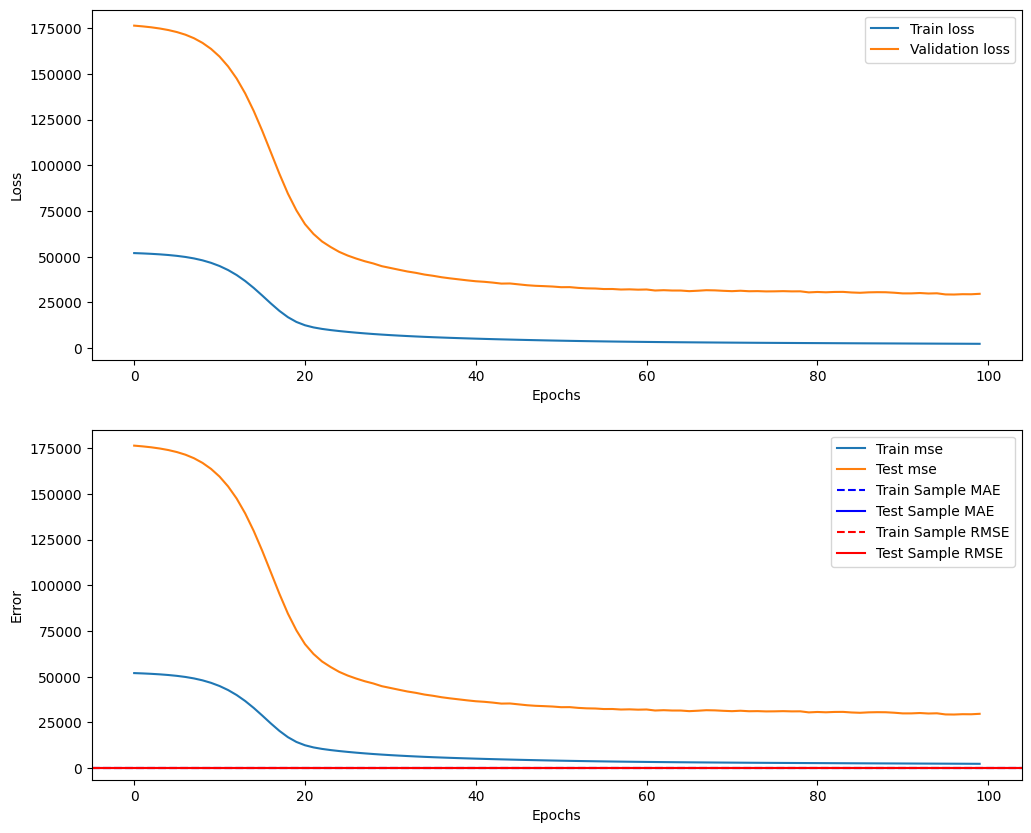

,MAE,MSE,RMSE,MAPE,R2
0,164.592202,29738.837445,172.449521,38.705753,-32.993848


In [13]:
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error,
    mean_absolute_error,
)

mae_train = mean_absolute_error(ytrain_data, y_pred)
mae_test = mean_absolute_error(ytest_data, yt_pred)
mse_train = mean_squared_error(ytrain_data, y_pred)
mse_test = mean_squared_error(ytest_data, yt_pred)
rmse_train = mean_squared_error(ytrain_data, y_pred, squared=False)
rmse_test = mean_squared_error(ytest_data, yt_pred, squared=False)
mape_train = mean_absolute_percentage_error(ytrain_data, y_pred) * 100
mape_test = mean_absolute_percentage_error(ytest_data, yt_pred) * 100


print(f"shapes y_pred: {y_pred.shape} and yt_pred: {yt_pred.shape}")

r2 = r2_score(
    ytest_data,
    yt_pred,
)
metrics_df = pd.DataFrame(
    {
        "MAE": [mae_test],
        "MSE": [mse_test],
        "RMSE": [rmse_test],
        "MAPE": [mape_test],
        "R2": [r2],
    }
)

fig, axs = plt.subplots(2, 1, figsize=(12, 10))

axs[0].plot(history.history["loss"], label="Train loss")
axs[0].plot(history.history["val_loss"], label="Validation loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[1].plot(
    history.history[TARGET_METRIC],
    label=f"Train {TARGET_METRIC}",
)
axs[1].plot(
    history.history[f"val_{TARGET_METRIC}"],
    label=f"Test {TARGET_METRIC}",
)
axs[1].axhline(mae_test, color="b", linestyle="--", label="Train Sample MAE")
axs[1].axhline(mae_train, color="b", linestyle="-", label="Test Sample MAE")
axs[1].axhline(rmse_train, color="r", linestyle="--", label="Train Sample RMSE")
axs[1].axhline(rmse_test, color="r", linestyle="-", label="Test Sample RMSE")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Error")
axs[1].legend()
plt.show()

metrics_df

# Conclusion




![]()

## References

- [YFinance Github](https://github.com/ranaroussi/yfinance)
- [Vanguard All World excluding US](https://investor.vanguard.com/investment-products/etfs/profile/veu)


## Github

Article here is also available on [Github]()

Kaggle notebook available [here]()


## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.